<a href="https://colab.research.google.com/github/abyanjan/Image-Retrieval-with-Autoencoders/blob/master/content_based_image_retrival_with_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoencoders for Content-Based Image Retrival with Tensorflow and Keras

In [62]:
! pip install -q imutils

In [63]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as k
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
from imutils import build_montages

### Implementing Convolutional Autoencoder

In [2]:
class ConvAutoencoder:
  @staticmethod
  def build(width, height, depth, latentdim=16):
    # initiallize the input shape with channel as last dimension
    input_shape = (height, width, depth)
    chanDim = -1

    inputs = Input(shape=input_shape)
    # build the encoder
    encoder = Sequential(layers=[
      #InputLayer(input_shape=input_shape,),                          
      Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same' ),
      LeakyReLU(alpha=0.2),
      BatchNormalization(axis=chanDim),
      Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same'),
      LeakyReLU(alpha=0.2),
      BatchNormalization(axis=chanDim)
    ])
    x = encoder(inputs)
    # flatten the encoder network and then construct our latent vector
    volumeSize = k.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latentdim, name="encoded")(x)
  
    # build the decoder from the latent output of the encoder
    # prepare the input to decoder
    decoder = Sequential(layers=[
      Dense(np.prod(volumeSize[1:]), input_dim = latentdim),
      Reshape((volumeSize[1], volumeSize[2], volumeSize[3])),
      Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, padding='same'),
      LeakyReLU(alpha=0.2),
      BatchNormalization(axis=chanDim),
      Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, padding='same'),
      LeakyReLU(alpha=0.2),
      BatchNormalization(axis=chanDim),
      Conv2DTranspose(filters=depth, kernel_size=(3,3), strides=1, padding='same'),
      Activation('sigmoid', name = 'decoded')
    ])

    # get the output from decoder
    outputs = decoder(latent)

    # build the autoencoder model
    autoencoder = Model(inputs, outputs)

    return encoder, decoder, autoencoder



In [3]:
encoder, decoder, autoencoder = ConvAutoencoder.build(width=28, height=28, depth=1)

In [4]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
Total params: 19,200
Trainable params: 19,008
Non-trainable params: 192
__________________________________________________

In [5]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 28, 28, 32)       

In [6]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 7, 7, 64)          19200     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
encoded (Dense)              (None, 16)                50192     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         109377    
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


### Loading the MNIST Data

In [7]:
((train_x,_),(test_x,_)) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
train_x.shape, test_x.shape

((60000, 28, 28), (10000, 28, 28))

In [9]:
# adding channel dimension to the images
train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

train_x.shape,  test_x.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [10]:
# normalizing the images
train_x = train_x.astype('float')/255.0
test_x = test_x.astype('float')/255.0

### Training the Autoencoder

In [11]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

optimizer = Adam(learning_rate=INIT_LR, decay = INIT_LR/EPOCHS)

# compile the model
autoencoder.compile(optimizer=optimizer, loss='mse')

In [12]:
# train the auto encoder
history = autoencoder.fit(train_x, train_x,
                          validation_data = (test_x, test_x),
                          batch_size = BS,
                          epochs=EPOCHS)

Epoch 1/20
1875/1875 [==============================] - 39s 4ms/step - loss: 0.0183 - val_loss: 0.0121
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 9/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.00

### Performance Curve

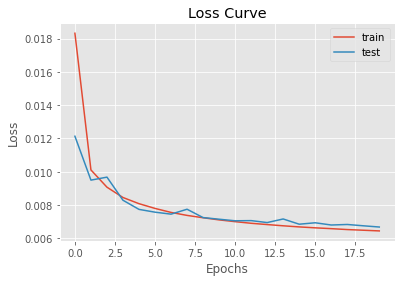

In [13]:
epochs = np.arange(0, EPOCHS)
plt.style.use('ggplot')
plt.figure()
plt.plot(epochs, history.history['loss'], label = 'train')
plt.plot(epochs, history.history['val_loss'], label = 'test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

### Plotting the Actual Images and Constructed Images with the Autoencoder

In [14]:
def visualize_predictions(decoded, orig, samples=10):
  # initialize our list of output images
  outputs = None

  # get some random image indexes from test data
  indx = np.random.randint(0, len(test_x), samples)

  # loop over our number of output samples
  for i in indx:
    # grab the original image and reconstructed image
    original = (orig[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")

    # stack the original and reconstructed image vertically
    output = np.vstack([original, recon])

    # if the outputs array is empty, initialize it as the current
		# vertically stackeed image display
    if outputs is None:
      outputs = output
    # otherwise, horizontally stack the outputs
    else:
      outputs = np.hstack([outputs, output])
  
  # return the output images
  return outputs


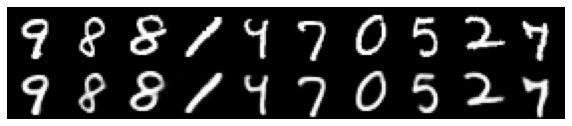

In [17]:
#make predictions on the test data
decoded = autoencoder.predict(test_x)

# visualize the results
vis_img = visualize_predictions(decoded=decoded, orig=test_x, samples=10)
vis_img = np.squeeze(vis_img, axis=-1)

plt.figure(figsize=(10,3))
plt.imshow(vis_img, cmap='gray', vmin=0, vmax=255 )
plt.axis('off');

In [18]:
# save the autoencoder model
autoencoder.save('autoencoder.h5')

## Implemetnting Image Search Retrival with Autoencoder

### Creating Latent Features for the Images with the trained Autoencoder

In [33]:
# load the mnist data
((train_x, _), (test_x, _)) = mnist.load_data()

In [34]:
# add channel dimension and normalize the images
train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

train_x = train_x.astype('float32')/255.0
test_x = test_x.astype('float32')/255.0

In [35]:
# create the encoder model which consists of just the encoder
# portion of the autoencoder so that we can extract the latent vectors

#load the autoencoder model
autoencoder = load_model('autoencoder.h5')

encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 7, 7, 64)          19200     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
encoded (Dense)              (None, 16)                50192     
Total params: 69,392
Trainable params: 69,200
Non-trainable params: 192
_________________________________________________________________


 **Get the latent features for the train images**

In [36]:
# get the latent features
features = encoder.predict(train_x)

In [37]:
features.shape

(60000, 16)

In [38]:
# store the features with a index label assigned
indexes = list(range(0, train_x.shape[0]))
features_data = {'index':indexes, 'feature':features}

# save the features data
with open('features_data.pkl','wb') as f:
  pickle.dump(features_data, f)

### Image Search Implementation

Using Euclidean Distance with the latent features, similar images to an input query images will be displayed.

In [31]:
def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

In [32]:
def perform_search(query, index, maxResults = 64):
  #intitalize the search results
  results = []

  # loop over our index
  for i in range(0, len(index['feature'])):
    # caluclate distance between the query features and all the
    # features in the index and store the results
    d = euclidean(query, index['feature'][i]) 
    results.append((d, i))

    # sort the results and keep only the maxResults
    results = sorted(results)[:maxResults]

  return results

**Perform the Image Search**

Taking a query image from test data and search similar images from the train data

In [46]:
# get latent features for the test data
test_features = encoder.predict(test_x)

In [140]:
# randomly select sample ids from test data
queryidxs = np.random.choice(range(len(test_x)), 10, replace=False)

# store the final results
final_results = []

#loop over the query idxs
for queryidx in queryidxs.tolist():
  # get the latent feature for query id
  queryfeature = test_features[queryidx]
  
  # perform the search
  results = perform_search(query=queryfeature, index=features_data, maxResults=100)

  # get the images from the results
  search_images = []
  for (d, i) in results:
    # get the image at the index i and convert it back to the range
    # [0, 255] and to 3 channels, and update the image list
    img = (train_x[i]*255).astype('uint8')
    img = np.dstack([img]*3)
    search_images.append(img)

  # build montages of the search results
  montage = build_montages(search_images, (28, 28), (10,10))[0]

  # get the query image
  query_img = (test_x[queryidx]*255).astype('uint8')
  query_img = np.dstack([query_img]*3)

  # combine the query image and the search results, vertically stack them
  h, w = montage.shape[:2]

  query_img = cv2.resize(query_img, (w, int(h/3)))
  final_img = np.vstack((query_img, montage))

  # update the final results
  final_results.append(final_img)


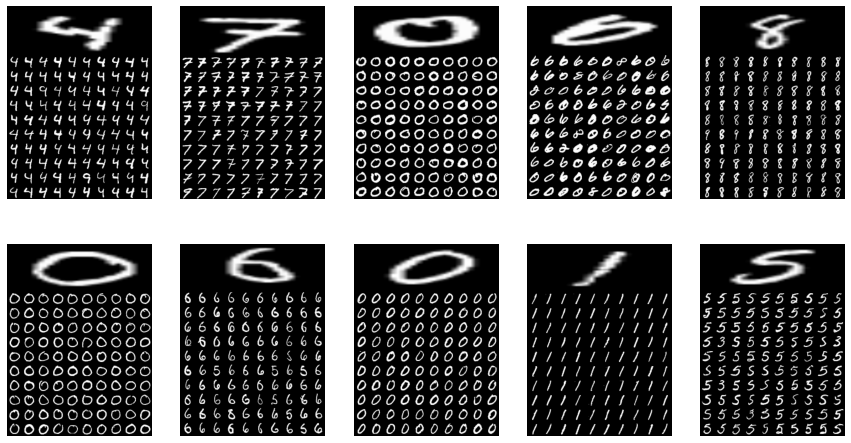

In [144]:
# visualize the results
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.ravel()
for i in range(len(ax)):
  ax[i].imshow(final_results[i])
  ax[i].axis('off')


## Creating an App for the Image Search with Gradio

In [145]:
!pip install -q gradio

     |████████████████████████████████| 2.1 MB 8.3 MB/s 
     |████████████████████████████████| 206 kB 67.9 MB/s 
     |████████████████████████████████| 1.9 MB 32.0 MB/s 
     |████████████████████████████████| 63 kB 2.8 MB/s 
     |████████████████████████████████| 3.2 MB 54.3 MB/s 
     |████████████████████████████████| 961 kB 59.8 MB/s 


In [146]:
import gradio as gr

In [147]:
# load the autoencoder model
autoencoder = load_model('autoencoder.h5')

# create only the encoder part 
encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)

In [148]:
# load the mnist data
((train_x, _), (test_x, _)) = mnist.load_data()

# combine train and test data
img_data = np.vstack((train_x, test_x))

# add channel dimension and normalize the images
img_data = np.expand_dims(img_data, axis=-1)
img_data = img_data.astype('float32')/255.0

In [149]:
img_data.shape

(70000, 28, 28, 1)

In [150]:
# get the latent features
lat_features = encoder.predict(img_data)

In [168]:
# store the lat features with their indexes
indexes = list(range(0, img_data.shape[0]))
index_data = {'index':indexes, 'feature':lat_features}

**Create the App**

In [392]:
def search_digits(input_array):

  # add channel 
  input_array = np.expand_dims(input_array, -1)

  # normalize the input
  query = input_array/ 255.0

  # add batch dimension
  query = np.expand_dims(query, axis=0)

  # get the latent features
  query_feature = encoder.predict(query)
  # perform the serach
  results = perform_search(query=query_feature, index=index_data,maxResults=100)

  # get the images from the results
  search_images = []
  for (d, i) in results:
    # get the image at the index i and convert it back to the range
    # [0, 255] , and update the image list
    img = (img_data[i]*255).astype('uint8')
    img = np.dstack([img]*3)
    search_images.append(img)

  # build montages of the search results
  montage = build_montages(search_images, (28, 28), (10,10))[0]

  return montage


In [393]:
im = gr.inputs.Image(shape=(28, 28), image_mode='L', invert_colors=True, source="canvas")

In [394]:
interface = gr.Interface(fn = search_digits, inputs=im, outputs= 'image')

In [395]:
interface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://35436.gradio.app
Interface loading below...


KeyboardInterrupt: ignored